#### This notebook takes SLP fields from ERA5 and   
#### (1) computes modes of variability (NAO, EAP)  
#### (2) saves modes (PCs and EOF loadings) to disk for future use  
#### (3) plots modes (PCs and EOF loadings)

In [96]:
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
fig_path      = '../figures/'
data_path     = '../data/'

In [97]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd 
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker
from proj_utils import *
from mapping_utils import *

In [98]:
nao_c = '#dc267f'
eap_c = '#fe6100'

## (1) Open SLP data (source: ERA5)

In [99]:
ds_slp = xr.open_dataset(data_path + 'north_atlantic_slp.nc')

In [100]:
ds_slp

<xarray.Dataset> Size: 1GB
Dimensions:    (longitude: 361, latitude: 281, expver: 2, time: 380)
Coordinates:
  * longitude  (longitude) float32 1kB -90.0 -89.75 -89.5 ... -0.5 -0.25 0.0
  * latitude   (latitude) float32 1kB 90.0 89.75 89.5 89.25 ... 20.5 20.25 20.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-08-01
Data variables:
    lsm        (time, expver, latitude, longitude) float64 617MB ...
    msl        (time, expver, latitude, longitude) float64 617MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-21 03:35:51 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## (2) Do some processing 

In [101]:
ds_slp = ds_slp.sel(expver = slice(0,1)).squeeze()
ds_slp = ds_slp.drop_vars('expver')
ds_slp = ds_slp.sel(time = slice('1993-01-01','2022-12-01'))
ds_slp = ds_slp.sortby(ds_slp.latitude)

In [102]:
ds_slp = seasonal_detrend(ds_slp)

## (3) Using EOF function, compute first few modes of SLP var

In [103]:
eofs, pcs, per_var, eigs = calc_eofs(ds_slp['msl'], num_modes=4)

/Users/lillienders/gs-var/scripts/proj_utils.py:412: RuntimeWarning: invalid value encountered in sqrt
  wgts = np.sqrt(coslat)[..., np.newaxis]


## (4) Plot spatial patterns, check signs

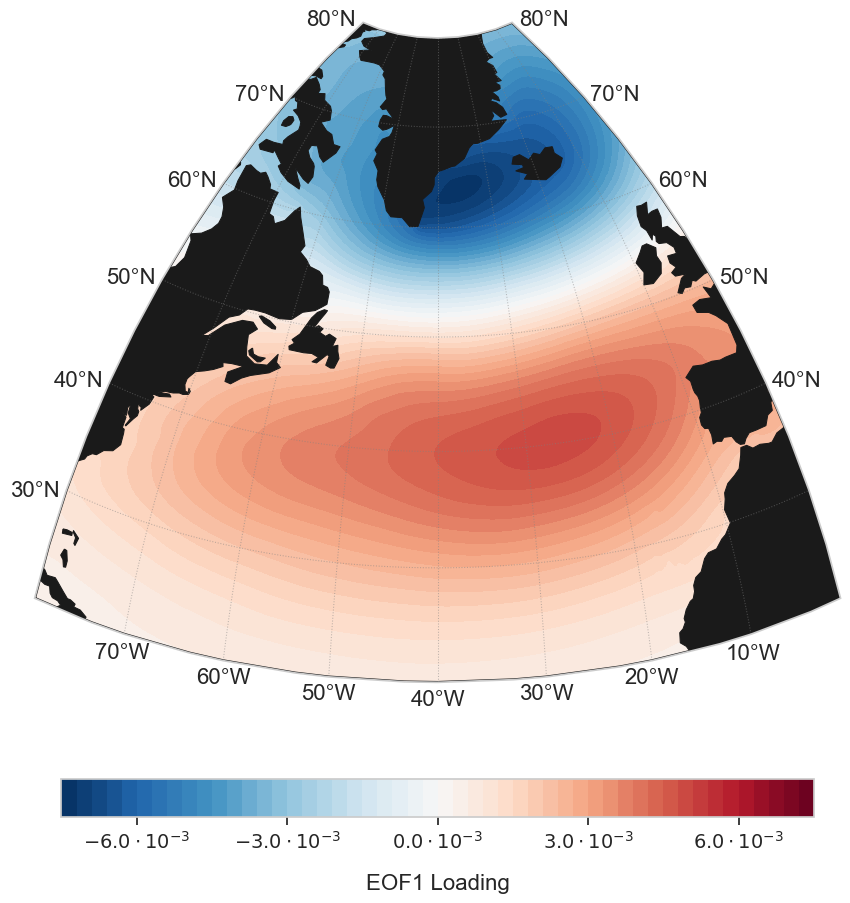

In [104]:
# --- Plotting spatial patterns ---
# --- this is important because based on the spatial patterns we decide whether the EOF sign needs to be inverted ---
var_to_plot   = -eofs[0,:,:]
cmax          = 0.0075
var_to_plot.data[var_to_plot.data > cmax] = cmax
var_to_plot.data[var_to_plot.data < -cmax] = -cmax

bbox          = [-80,0,20,80]           # Plotting Extent
plot_this_box = [-80,0,0,60]            # Locator box indicating a region
proj          = ccrs.PlateCarree()      # Need to add this to most things as "transform=proj"
fig,ax,_      = init_orthomap(1,1,bbox)

ax     = add_coast_grid(ax,bbox,fill_color='k',line_color='k') # Add Coasts/Continent

levels = np.linspace(-cmax,cmax,51)

colorplot = ax.contourf(ds_slp.longitude,ds_slp.latitude,var_to_plot,transform=proj, levels=levels, cmap='RdBu_r', zorder=0) # Plot contours (filled)

cbar = plt.colorbar(colorplot, fraction=0.057, pad=0.1, orientation='horizontal',ticks=np.linspace(-0.006, 0.006, 5))
cbar.ax.tick_params(labelsize=14)
cbar.set_ticklabels([r'$-6.0 \cdot 10^{-3}$', r'$-3.0 \cdot 10^{-3}$', r'$0.0 \cdot 10^{-3}$', 
                     r'$3.0 \cdot 10^{-3}$', r'$6.0 \cdot 10^{-3}$'])
cbar.set_label('EOF1 Loading', size='16', labelpad=15)

plt.savefig(fig_path  + 'full_year_nao_full_period.png', format='png', bbox_inches="tight",dpi=500)

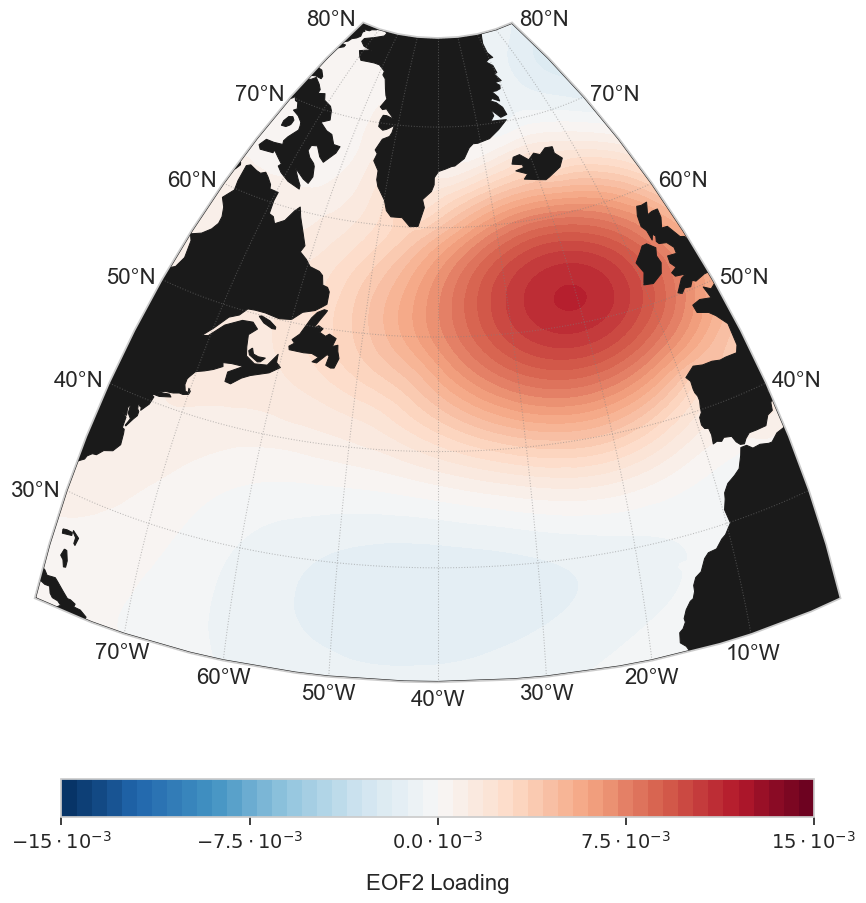

In [105]:
# --- Plotting spatial patterns ---
# --- this is important because based on the spatial patterns we decide whether the EOF sign needs to be inverted ---
var_to_plot   = -eofs[1,:,:]
cmax          = 0.015
var_to_plot.data[var_to_plot.data > cmax] = cmax
var_to_plot.data[var_to_plot.data < -cmax] = -cmax

bbox          = [-80,0,20,80]           # Plotting Extent
plot_this_box = [-80,0,0,60]            # Locator box indicating a region
proj          = ccrs.PlateCarree()      # Need to add this to most things as "transform=proj"
fig,ax,_      = init_orthomap(1,1,bbox)

ax     = add_coast_grid(ax,bbox,fill_color='k',line_color='k') # Add Coasts/Continent

levels = np.linspace(-cmax,cmax,51)

colorplot = ax.contourf(ds_slp.longitude,ds_slp.latitude,var_to_plot,transform=proj, levels=levels, cmap='RdBu_r', zorder=0) # Plot contours (filled)

cbar = plt.colorbar(colorplot, fraction=0.057, pad=0.1, orientation='horizontal',ticks=np.linspace(-0.015, 0.015, 5))
cbar.ax.tick_params(labelsize=14)
cbar.set_ticklabels([r'$-15 \cdot 10^{-3}$', r'$-7.5 \cdot 10^{-3}$', r'$0.0 \cdot 10^{-3}$', 
                     r'$7.5 \cdot 10^{-3}$', r'$15 \cdot 10^{-3}$'])
cbar.set_label('EOF2 Loading', size='16', labelpad=15)

plt.savefig(fig_path  + 'full_year_eap_full_period.png', format='png', bbox_inches="tight",dpi=500)

## (5) Save time series and patterns with correct signs

In [106]:
nao_ts    = -pcs[:,0]
eap_ts    = -pcs[:,1]

nao_sp    = -eofs[0,:,:]
eap_sp    = -eofs[1,:,:]

In [112]:
# These are commented out because we've already saved them, so don't need to save them again
#nao_ts.to_netcdf(data_path + 'nao_era5_timeseries.nc')
#eap_ts.to_netcdf(data_path + 'eap_era5_timeseries.nc')

#nao_sp.to_netcdf(data_path + 'nao_era5_spatial_pattern.nc')
#eap_sp.to_netcdf(data_path + 'eap_era5_spatial_pattern.nc')

#per_var.to_netcdf(data_path + 'slp_eofs_per_var.nc')

## (6) Filter PCs just for plotting purposes

In [108]:
nao_f    = lanczos_bandpass(nao_ts, low_freq = 12*6, high_freq = 12*11, window = 12) 
nao_f    = (nao_f - nao_f.mean(dim='time'))/nao_f.std(dim = 'time')

eap_f    = lanczos_bandpass(eap_ts, low_freq = 12*6, high_freq = 12*11, window = 12) 
eap_f    = (eap_f - eap_f.mean(dim='time'))/eap_f.std(dim = 'time')

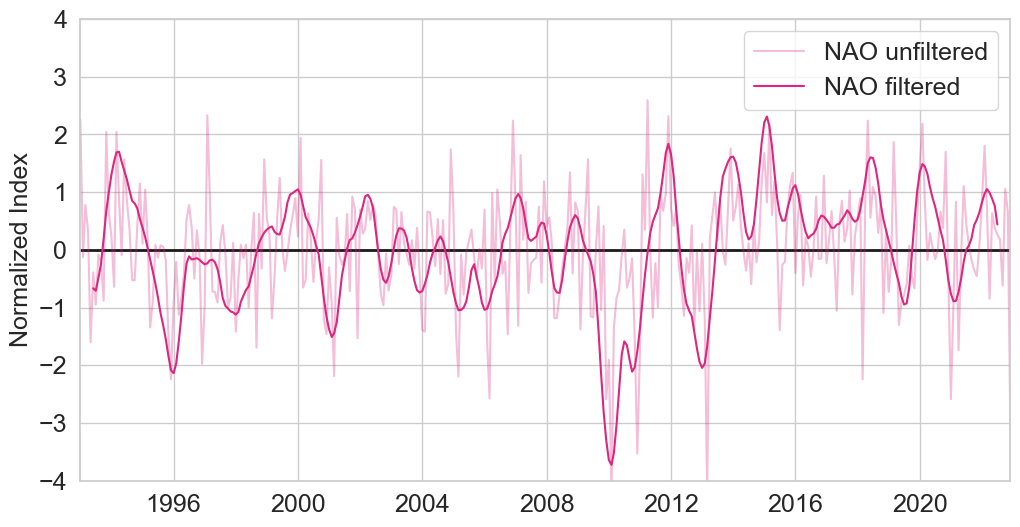

In [109]:
style = sns.set_style("whitegrid")

fig   = plt.figure(figsize=(12, 6))
zline = plt.axhline(0, color='k', linewidth=2)

uf    = plt.plot(nao_ts.time, nao_ts, color = nao_c, alpha = 0.3, label = 'NAO unfiltered')
f     = plt.plot(nao_f.time, nao_f, color = nao_c, zorder = 10, label = 'NAO filtered')

xtix  = plt.yticks(fontsize=18)
ytix  = plt.xticks(fontsize=18)

ylab  = plt.ylabel('Normalized Index', fontsize = 18)
xlab  = plt.xlabel('',fontsize = 18)

xlim  = plt.xlim(nao_ts.time[0],nao_ts.time[-1])
ylim  = plt.ylim(-4,4)

leg   = plt.legend(fontsize = 18)

plt.savefig(fig_path + 'nao_time_series_era5.png', format='png', bbox_inches="tight",dpi=500)

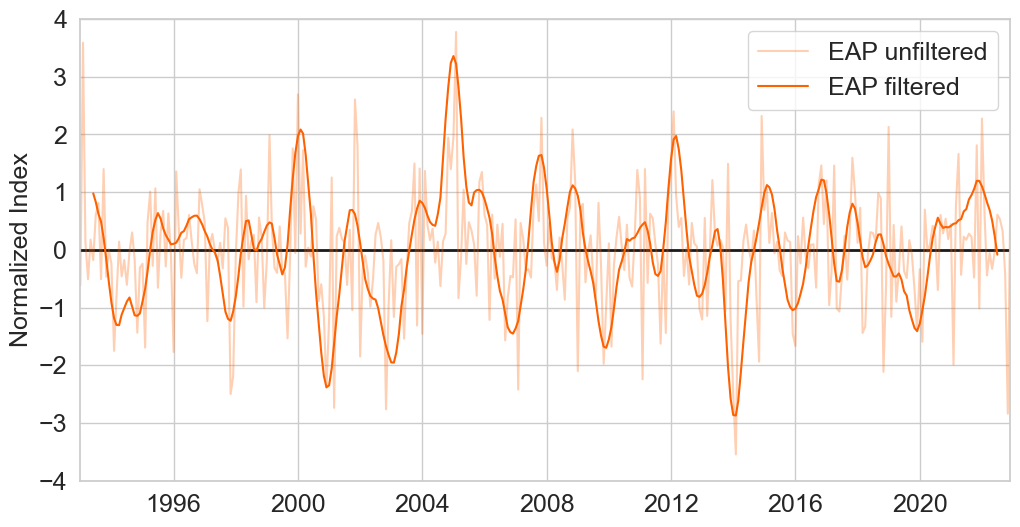

In [110]:
style = sns.set_style("whitegrid")

fig   = plt.figure(figsize=(12, 6))
zline = plt.axhline(0, color='k', linewidth=2)

uf    = plt.plot(eap_ts.time, eap_ts, color = eap_c, alpha = 0.3, label = 'EAP unfiltered')
f     = plt.plot(eap_f.time, eap_f, color = eap_c, zorder = 10, label = 'EAP filtered')

xtix  = plt.yticks(fontsize=18)
ytix  = plt.xticks(fontsize=18)

ylab  = plt.ylabel('Normalized Index', fontsize = 18)
xlab  = plt.xlabel('',fontsize = 18)

xlim  = plt.xlim(eap_ts.time[0],eap_ts.time[-1])
ylim  = plt.ylim(-4,4)

leg   = plt.legend(fontsize = 18)

plt.savefig(fig_path + 'eap_time_series_era5.png', format='png', bbox_inches="tight",dpi=500)